<a href="https://colab.research.google.com/github/priyankadeep/Analysis-of-Ted-Talks/blob/main/Data_Science_Project_Popular_Ted_Talks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#importing all relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Reading the csv files
pd.set_option('display.max_columns', None)
df_main=pd.read_csv("/content/drive/MyDrive/ted_main1.csv")
df_transcript=pd.read_csv("/content/drive/MyDrive/transcripts.csv")


In [ ]:
# undertake EDA on the files
df_transcript.info()
df_main.info()
df_main.head()

In [ ]:

# II. EDA
print(f"The total % missing values in the dataframe are shown here:\n {df_main.isna().sum()/df_main.shape[0]}")
### 2. Total numeric input columns: 4 (Comments, duration, languages, num_speaker)
### 3.a. Total categorical (simple) input columns: 6 (event, film_date, main speaker, name [note: this is a combo of name & title], speaker occupation, published date)
### 3.b. Total categorical (complex) input columns: 2 (ratings, tags)
### 4. Total unstructured data-based input columns: 2 (description, title)
### 5. Target column = views
### 6. columns we can discard = 2 (related talks, url)

The total % missing values in the dataframe are shown here:
 comments              0.0
description           0.0
duration              0.0
event                 0.0
film_date             0.0
languages             0.0
main_speaker          0.0
name                  0.0
num_speaker           0.0
published_date        0.0
ratings               0.0
related_talks         0.0
speaker_occupation    0.0
tags                  0.0
title                 0.0
url                   0.0
views                 0.0
dtype: float64


In [ ]:
# III. Data Preparation, Wrangling & Pre-processing
print(df_main.columns)


Index(['comments', 'description', 'duration', 'event', 'film_date',
       'languages', 'main_speaker', 'name', 'num_speaker', 'published_date',
       'ratings', 'related_talks', 'speaker_occupation', 'tags', 'title',
       'url', 'views'],
      dtype='object')


In [ ]:
## Wrangle with simple categorical columns, first
simple_cat_cols = ['event', 'film_date', 'main_speaker', 'name', 'speaker_occupation', 'published_date']
simple_cat_cols = [col1 for col1 in simple_cat_cols if col1!='name']
df_main[simple_cat_cols].head()
text_cols = ['event', 'main_speaker', 'speaker_occupation', 'description', 'title']
# pre-process the text-based cols + understand a potential level of impact (lower the average rows/unique category --> lower the plausible statistical impact on the target columns)
for col in text_cols:
    df_main[col] = df_main[col].astype(str).str.lower()
    print(f"\n\nFor column {col}:\n\tThere were {df_main[col].nunique()} unique values found.\n\tThis means an average of {df_main.shape[0]/df_main[col].nunique()} rows/unique category")
df_main[simple_cat_cols].describe()




For column event:
	There were 355 unique values found.
	This means an average of 7.183098591549296 rows/unique category


For column main_speaker:
	There were 2156 unique values found.
	This means an average of 1.1827458256029684 rows/unique category


For column speaker_occupation:
	There were 1442 unique values found.
	This means an average of 1.7683772538141471 rows/unique category


For column description:
	There were 2550 unique values found.
	This means an average of 1.0 rows/unique category


For column title:
	There were 2550 unique values found.
	This means an average of 1.0 rows/unique category


,film_date,published_date
count,2.550000e+03,2.550000e+03
mean,1.321928e+09,1.343525e+09
std,1.197391e+08,9.464009e+07
min,7.464960e+07,1.151367e+09
25%,1.257466e+09,1.268463e+09
50%,1.333238e+09,1.340935e+09
75%,1.412964e+09,1.423432e+09
max,1.503792e+09,1.506092e+09


In [ ]:

def label_encode(col_name, df):
    label_encoder = preprocessing.LabelEncoder()
    # Encode labels in column.
    df[col_name]= label_encoder.fit_transform(df[col_name])
    return df

In [ ]:
def find_punctuations(text):
    result = re.findall(r'[!"\$%&\'()*+,\-.\/:;=#@?\[\\\]^_`{|}~]*', text)
    string="".join(result)
    return list(string)

In [ ]:
def unique_punctuations_in_col(col_name2, df2, remove=False):
    col_name_new = col_name2+"__punc"
    df2[col_name_new] = df2[col_name2].apply(lambda x: find_punctuations(x))
    unique_puncs = list(set(np.concatenate(df_main[col_name_new])))
    print(f"\nThe unique punctuations detected in col {col_name2} are: \n\t{unique_puncs}")
    for punc in unique_puncs:
        print(f"\n\n{punc}")
        if punc in ['(', ')', '+', '*', '[', ']', '?']:
            punc = '\\' + punc
            #punc = punc[1:]
        print(punc)
        temp_df = df2[col_name2][df2[col_name2].str.contains(punc)]
        print(f"\nFor Punctuation, {punc}, some of the values are as follows:\n\t{temp_df}")
        if remove==True:
            df2[col_name_new] = df2[col_name_new].apply(lambda x: str(x).replace(punc, " "))
    print(f"\nThe unique punctuations detected in col {col_name2} are: \n\t{unique_puncs}")
    return df2

In [ ]:
# label encode key categorical columns
df_main = label_encode(col_name="event", df=df_main)
df_main = label_encode(col_name="main_speaker", df=df_main)
df_main = label_encode(col_name="film_date", df=df_main)
df_main = label_encode(col_name="published_date", df=df_main)
# determine key punctuations present in text columns. especially helpful to process the speaker_occupation column (multiple occupations are separated by varying punctuation marks)
df_main = unique_punctuations_in_col(col_name2="speaker_occupation", df2=df_main)
df_main = unique_punctuations_in_col(col_name2="description", df2=df_main)
df_main = unique_punctuations_in_col(col_name2="title", df2=df_main)

In [ ]:
# prep tags column so it can be used in TFIDF transformation below
df_main['tags__lower'] = df_main.tags.map(str.lower)
print(df_main.tags__lower.head())

In [ ]:
# prep speaker occupation cxolumn so it can be used in TFIDF transformation below
df_main['speaker_occupation__lst'] = df_main.speaker_occupation.apply(lambda x: [k1.strip() for k1 in x.strip().replace(',', ';').replace('/',';').split(';')])
print(f"\nFound {len(list(set(np.concatenate(df_main.speaker_occupation__lst))))} unique occupations")
pd.DataFrame(np.concatenate(df_main.speaker_occupation__lst)).value_counts().plot.hist()
ct_profession = pd.DataFrame(np.concatenate(df_main.speaker_occupation__lst))
ct_profession_2 = ct_profession.value_counts()
print(f"\n\nTop occupations detected are as follows:\n\n{ct_profession_2.head(10)}")


In [ ]:
df_main

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views,speaker_occupation__punc,description__punc,title__punc,tags__lower,speaker_occupation__lst
0,4553,sir ken robinson makes an entertaining and pro...,1164,57,55,60,1127,Ken Robinson: Do schools kill creativity?,1,0,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",author/educator,"['children', 'creativity', 'culture', 'dance',...",do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110,[/],"[(, ), .]",[?],"['children', 'creativity', 'culture', 'dance',...","[author, educator]"
1,265,with the same humor and humanity he exuded in ...,977,57,55,43,33,Al Gore: Averting the climate crisis,1,0,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",climate advocate,"['alternative energy', 'cars', 'climate change...",averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520,[],"["", ,, "", ,, ,, .]",[],"['alternative energy', 'cars', 'climate change...",[climate advocate]
2,124,new york times columnist david pogue takes aim...,1286,57,54,26,507,David Pogue: Simplicity sells,1,0,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",technology columnist,"['computers', 'entertainment', 'interface desi...",simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...,1636292,[],"[-, ,, ., ,, .]",[],"['computers', 'entertainment', 'interface desi...",[technology columnist]
3,200,"in an emotionally charged talk, macarthur-winn...",1116,57,56,35,1254,Majora Carter: Greening the ghetto,1,0,"[{'id': 3, 'name': 'Courageous', 'count': 760}...","[{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...",activist for environmental justice,"['MacArthur grant', 'activism', 'business', 'c...",greening the ghetto,https://www.ted.com/talks/majora_carter_s_tale...,1697550,[],"[,, -, -, -, .]",[],"['macarthur grant', 'activism', 'business', 'c...",[activist for environmental justice]
4,593,you've never seen data presented like this. wi...,1190,57,52,48,768,Hans Rosling: The best stats you've ever seen,1,1,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","[{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...",global health expert; data visionary,"['Africa', 'Asia', 'Google', 'demo', 'economic...",the best stats you've ever seen,https://www.ted.com/talks/hans_rosling_shows_t...,12005869,[;],"[', ., ,, -, "", ., ""]",['],"['africa', 'asia', 'google', 'demo', 'economic...","[global health expert, data visionary]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2545,17,"between 2008 and 2016, the united states depor...",476,68,731,4,564,Duarte Geraldino: What we're missing in the de...,1,2485,"[{'id': 3, 'name': 'Courageous', 'count': 24},...","[{'id': 2596, 'hero': 'https://pe.tedcdn.com/i...",journalist,"['TED Residency', 'United States', 'community'...",what we're missing in the debate about immigra...,https://www.ted.com/talks/duarte_geraldino_wha...,450430,[],"[,, ., ?, ., ,, .]",['],"['ted residency', 'united states', 'community'...",[journalist]
2546,6,how can you study mars without a spaceship? he...,290,68,729,3,171,Armando Azua-Bustos: The most Martian place on...,1,2486,"[{'id': 22, 'name': 'Fascinating', 'count': 32...","[{'id': 2491, 'hero': 'https://pe.tedcdn.com/i...",astrobiologist,"['Mars', 'South America', 'TED Fellows', 'astr...",the most martian place on earth,https://www.ted.com/talks/armando_azua_bustos_...,417470,[],"[?, -, -, ., -, ,, ,, ., ,, .]",[],"['mars', 'south america', 'ted fellows', 'astr...",[astrobiologist]
2547,10,science fiction visions of the future show us ...,651,68,729,1,1628,Radhika Nagpal: What intelligent machines can ...,1,2487,"[{'id': 1, 'name': 'Beautiful', 'count': 14}, ...","[{'id': 2346, 'hero': 'https:

In [ ]:
# prep Title column so it can be used in TFIDF transformation below
stop_eng = stopwords.words('english')
def prep_text_cols(df4, col_name4, stopwrds=stop_eng):
    col_name4_new = col_name4+"__lower"
    df4[col_name4_new] = df4[col_name4].apply(str.lower).apply(str.strip)
    df4[col_name4_new] = df4[col_name4_new].apply(lambda x: re.sub(r'[^\w\s]', '', x))
    df4[col_name4_new] = df4[col_name4_new].apply(lambda x: [w for w in x.split() if w not in stopwrds])
    df4[col_name4_new] = df4[col_name4_new].apply(lambda x: ['ignore'] if len(x)==0 else x)
    return df4

In [ ]:
# scale and transform numeric cols
scaler = StandardScaler()
numeric_cols = ['comments', 'duration', 'languages', 'num_speaker']
df_main[numeric_cols] = scaler.fit_transform(df_main[numeric_cols])

# scale and transform categoric cols
categoric_cols = ['event', 'film_date', 'main_speaker', 'published_date']

df_main = prep_text_cols(df4=df_main, col_name4="title", stopwrds=stop_eng)
df_main = prep_text_cols(df4=df_main, col_name4="description", stopwrds=stop_eng)
print(df_main.title__lower.head())

0         [schools, kill, creativity]
1         [averting, climate, crisis]
2                 [simplicity, sells]
3                  [greening, ghetto]
4    [best, stats, youve, ever, seen]
Name: title__lower, dtype: object


In [ ]:
def get_vectorized_top_results(df3, col_name3, max_cols):
    unique_occ = df3[col_name3].explode()
    vectorizer = TfidfVectorizer(max_features=max_cols)
    tfidf_matrx = vectorizer.fit_transform(unique_occ)
    col_names = [k8+'__'+col_name3[:4] for k8 in vectorizer.get_feature_names_out()]
    tfidf_df = pd.DataFrame(tfidf_matrx.toarray(), columns = col_names, index=unique_occ.index)
    tfidf_df2 = tfidf_df.groupby(unique_occ.index).sum()
    data = pd.concat([df3, tfidf_df2], axis=1)
    return data

In [ ]:
## rule of thumb: we can have 10 rows for every column in an ML model.
## since we have 2500 rows, we choose to take upto 250 columns. this is reflected in the max columns for each tfidf matrix below
df_main2 = get_vectorized_top_results(df3=df_main, col_name3="speaker_occupation__lst", max_cols=50)
df_main3 = get_vectorized_top_results(df3=df_main2, col_name3="tags__lower", max_cols=50)
df_main4 = get_vectorized_top_results(df3=df_main3, col_name3="title__lower", max_cols=50)
df_main5 = get_vectorized_top_results(df3=df_main4, col_name3="description__lower", max_cols=50)


df_main.columns
df_main5

In [ ]:
##
cols_to_exclude = ['description', 'tags', 'title', 'url', 'speaker_occupation__lst', 'title__lower', 'description__lower', 'related_talks', 'speaker_occupation', 'views', 'name', 'ratings', 'speaker_occupation__punc', 'description__punc', 'title__punc', 'tags__lower']
X = df_main5[[k6 for k6 in df_main5.columns if k6 not in cols_to_exclude]]
y = df_main5['views']
print(X.columns[:20])


In [ ]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [ ]:
# Fit linear regression model on the training data
model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
# run cross-validation

#view model summary
print(model.summary())
## R-squared (uncentered):                   0.480
## Adj. R-squared (uncentered):              0.421

In [ ]:
import matplotlib.pyplot as plt

# Predicted values
y_pred = model.predict(sm.add_constant(X_test))

# Scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line
plt.xlabel('Actual Views')
plt.ylabel('Predicted Views')
plt.title('Actual vs. Predicted Views')
plt.grid(True)
plt.show()

In [ ]:
d = {}
for i in X.columns.tolist():
    d[f'{i}'] = model.pvalues[i]

df_pvalue = pd.DataFrame(d.items(), columns=['Var_name', 'p-Value']).sort_values(by='p-Value').reset_index(drop=True)

# Print the sorted dataframe
print(df_pvalue)
statistically_relevant_cols_df = df_pvalue[df_pvalue['p-Value']<=0.05]
print(f"Statistically relevant columns, as per the first pass include:\n{statistically_relevant_cols_df}")
X2 = df_main5[[k for k in statistically_relevant_cols_df['Var_name'] if k!='const']]
X2 - sm.add_constant(X2)
y2 = df_main5['views']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Fit linear regression model on the training data
model2 = sm.OLS(y2_train, sm.add_constant(X2_train)).fit()

#view model summary
print(model2.summary())
## R-squared (uncentered):                   0.429
## Adj. R-squared (uncentered):              0.425

## thus, by choosing only 18 relevant columns in X2 (1 additional is const) as opposed to 208 columns in X (1 additional is const), we have a better performing and more efficient model!
## check other models, regularization


Out of the various tags and occupation, it is observed that the keyword "Power" and "Science" in the title gathers more popularity. ALong with that, when the ted talk is being delivered by an expert on the matter, then it increases the likeliness of popularity. When the speaker's occupation is that of a comedian, that increases the popularity as well.

The model below is that of Gradient descent. The model is turning out to be really bad as the R-squared is about -2049.450713972905 and the MSE is about 6869485461510.814
Trying to use this model for the features we got from the linear regression model, this gives us a worse result. Hence, it wouldnt be meaningful to use this model for evaluation.

In [ ]:
X_gd = pd.concat((pd.DataFrame([1,5100]*2550), X2_train),axis=1, join='inner').to_numpy()
y_gd = y2_train.to_numpy()
def gradient_descent(X, y, alpha, epsilon, max_iter=10000):
    # Initialize theta with ones
    theta = np.ones(shape=(X.shape[1], 1))
    # Initialize iteration counter
    iterations = 0
    # Initialize cost
    cost = np.inf
    # Store cost history
    cost_history = []

    while iterations < max_iter:
        # Calculate predicted values
        y_pred = X.dot(theta)
        # Calculate error
        error = y_pred - y
        # Calculate cost
        current_cost = np.mean(error ** 2)
        # Store current cost in history
        cost_history.append(current_cost)

        # If the change in cost is smaller than epsilon, break
        if len(cost_history) > 1 and abs(cost_history[-1] - cost_history[-2]) < epsilon:
            break

        # Update theta
        theta = theta - (alpha / len(X)) * X.T.dot(error)

        # Update iteration count
        iterations += 1

    return theta, cost_history, iterations

# Concatenate a column of ones to the scaled feature matrix
X_scaled_with_bias = np.hstack((np.ones((X_gd.shape[0], 1)), preprocessing.scale(X_gd)))

# Apply gradient descent
theta, cost_history, iterations = gradient_descent(X_scaled_with_bias, y_gd[:, np.newaxis], alpha=0.01, epsilon=1e-10)

# Print results
print("Theta:", theta)
print("Number of iterations:", iterations)

def r_squared(y_true, y_pred):
    mean_y = np.mean(y_true)
    total_sum_of_squares = np.sum((y_true - mean_y) ** 2)
    residual_sum_of_squares = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (residual_sum_of_squares / total_sum_of_squares)
    return r2

# Calculate R-squared score
y_pred = X_scaled_with_bias.dot(theta)
r2 = r_squared(y_gd, y_pred)
print("R-squared score:", r2)

In [ ]:
def mean_squared_error(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    return mse

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_gd, y_pred)
print("Mean Squared Error:", mse)


def cross_validate(X, y, alpha, epsilon, n_folds=5):
    fold_size = len(X) // n_folds
    mse_scores = []

    for i in range(n_folds):
        # Split data into train and validation sets
        X_train = np.concatenate([X[:i*fold_size], X[(i+1)*fold_size:]])
        y_train = np.concatenate([y[:i*fold_size], y[(i+1)*fold_size:]])
        X_val = X[i*fold_size:(i+1)*fold_size]
        y_val = y[i*fold_size:(i+1)*fold_size]

        # Apply gradient descent on the training set
        theta, _, _ = gradient_descent(X_train, y_train, alpha, epsilon)

        # Predict on validation set
        y_pred = np.dot(X_val, theta)

        # Calculate MSE
        mse = mean_squared_error(y_val, y_pred)
        mse_scores.append(mse)

    return np.mean(mse_scores)

# Example usage
alpha = 0.01
epsilon = 1e-10
mse_cv = cross_validate(X_scaled_with_bias, y_gd[:, np.newaxis], alpha, epsilon)
print("Cross-validated MSE:", mse_cv)

Mean Squared Error: 6861682109264.452
Cross-validated MSE: 6869485461510.814


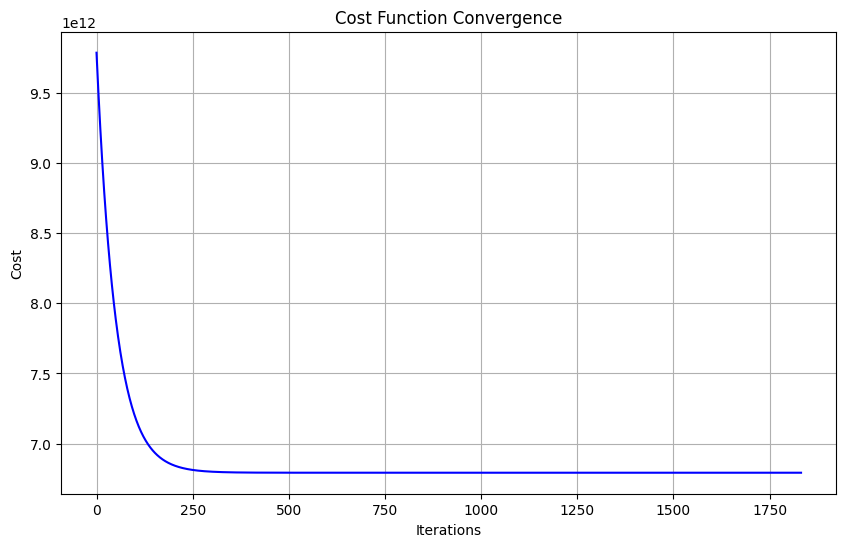

In [ ]:
# Plot cost function convergence
plt.figure(figsize=(10, 6))
plt.plot(range(iterations), cost_history[:iterations], color='blue')  # Adjusted range and cost_history length
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost Function Convergence')
plt.grid(True)
plt.show()



In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score,confusion_matrix,r2_score
# Assuming X_train, X_test, y_train, y_test are your training and testing data
# Feature selection and data preparation steps should be done beforehand

# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_regressor.fit(X2_train, y2_train)

# Make predictions on the test set
y_pred = rf_regressor.predict(X2_test)

# Evaluate the model
mse = mean_squared_error(y2_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate R-squared
r_squared = r2_score(y2_test, y_pred)
print("R-squared:", r_squared)

Mean Squared Error: 2233325324713.815
R-squared: 0.4248575906431118


In [ ]:
# Visualize the first decision tree
from sklearn import tree
plt.figure(figsize=(20, 12))
tree.plot_tree(rf_regressor.estimators_[0], filled=True)
plt.show()

In [ ]:
# Perform 10-fold cross-validation
cv_scores = cross_val_score(rf_regressor, X2_train, y2_train, cv=100)

# Calculate average accuracy
average_r_squared = cv_scores.mean()

print("Average R-squared:", average_r_squared)

The RF model below is being run on all columns in df_main5 except 'description', 'tags', 'title', 'url', 'speaker_occupation__lst', 'title__lower', 'description__lower', 'related_talks', 'speaker_occupation', 'views', 'name', 'ratings', 'speaker_occupation__punc', 'description__punc', 'title__punc', 'tags__lower'
The R-squared turned out to be slightly better in this case.

In [ ]:
# Initialize the Random Forest Regressor
rf_regressor1 = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_regressor1.fit(X_train, y_train)

# Make predictions on the test set
y_pred1 = rf_regressor1.predict(X_test)

# Evaluate the model
mse1 = mean_squared_error(y_test, y_pred1)
print("Mean Squared Error:", mse1)

# Calculate R-squared
r_squared1 = r2_score(y_test, y_pred1)
print("R-squared:", r_squared1)

# Perform 10-fold cross-validation
cv_scores1 = cross_val_score(rf_regressor1, X_train, y_train, cv=10)

# Calculate average accuracy
average_r_squared1 = cv_scores.mean()

print("Average R-squared:", average_r_squared1)

Mean Squared Error (Cross-Validation): 5994143653631.707
R-squared: -0.05676901450304661


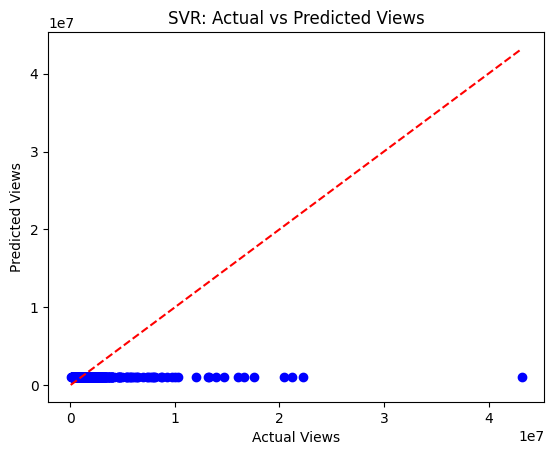

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Assume X_train, X_test, y_train, y_test are your training and testing data after preprocessing
X = df_main5.drop(columns=['views','description', 'tags', 'title', 'url', 'speaker_occupation__lst', 'title__lower', 'description__lower', 'related_talks', 'speaker_occupation', 'views', 'name', 'ratings', 'speaker_occupation__punc', 'description__punc', 'title__punc', 'tags__lower'])
y = df_main5['views']
X4_train, X4_test, y4_train, y4_test = train_test_split(X, y, test_size=0.3)

# Initialize the SVR model
svm_model = SVR()

# Fit the SVR model on training data
svm_model.fit(X4_train, y4_train)

# Perform cross-validation
scores = cross_val_score(svm_model, X4_train, y4_train, cv=20, scoring='neg_mean_squared_error')

# Print the mean squared error
print("Mean Squared Error (Cross-Validation):", -scores.mean())

# Predict on the test data
y4_pred = svm_model.predict(X4_test)

# Calculate R-squared
r2 = r2_score(y4_test, y4_pred)
print("R-squared:", r2)

# Plotting actual vs predicted values
plt.scatter(y4_test, y4_pred, color='blue')
plt.plot([min(y4_test), max(y4_test)], [min(y4_test), max(y4_test)], color='red', linestyle='--')
plt.xlabel('Actual Views')
plt.ylabel('Predicted Views')
plt.title('SVR: Actual vs Predicted Views')
plt.show()
